In [2]:
#import the necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0, VGG16

print ('modules loaded')

modules loaded


In [4]:
#create different filepaths with corresponding labels
def define_paths(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        fold_path = os.path.join(data_dir, fold)
        files = os.listdir(fold_path)
        for file in files:
            fpath = os.path.join(fold_path, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

#prepare a dataset with files and classes
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

#create train and test splits
def create_df(data_dir):
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    
    strat = df['labels']
    train_df, test_df = train_test_split(df,  train_size= 0.9, shuffle= True, random_state= 123, stratify= strat)
 
    return train_df, test_df

In [5]:
#creating image generators for train and test split
def create_gens(train_df, test_df):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    batch_size = 40
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, test_gen

In [6]:
def show_images(gen):
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes)
    images, labels = next(gen)        # get a batch size samples from the generator
    plt.figure(figsize= (20, 20))
    length = len(labels)              # length of batch size
    sample = min(length, 25)          # check if sample less than 25 images
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [8]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Testing loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Testing Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 159 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 17 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1174 validated image filenames belonging to 7 classes.
Found 132 validated image filenames belonging to 7 classes.


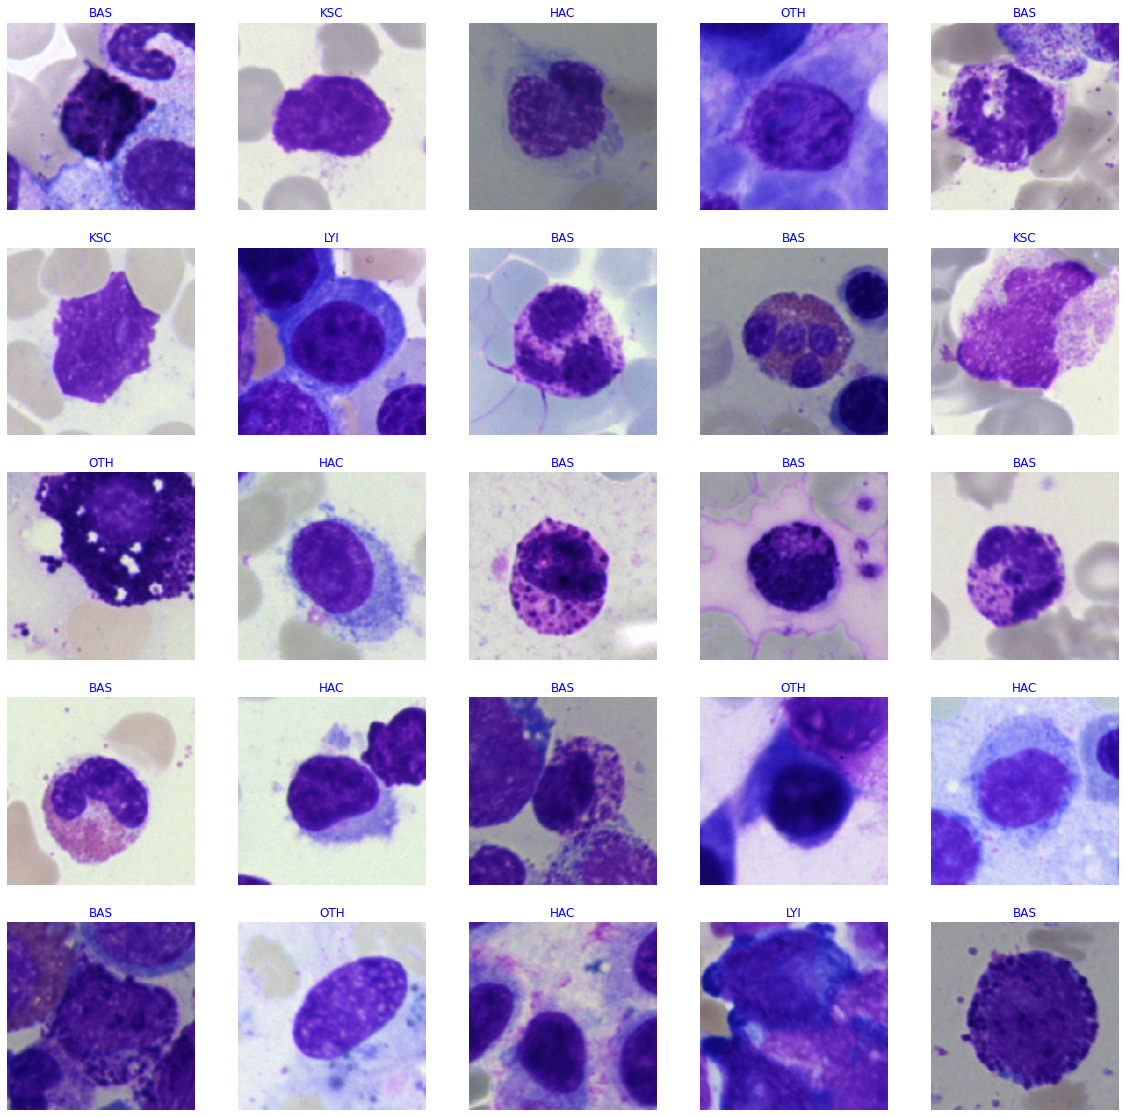

In [9]:
# Get Dataframes
data_dir = '../input/bone-marrow-cell-classification/bone_marrow_cell_dataset'
train_df, test_df = create_df(data_dir)

# Get Generators
train_gen, test_gen = create_gens(train_df, test_df)

show_images(train_gen)

### EfficientNetB5

In [10]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

115277824/115263384 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 29,048,062
Trainable params: 28,871,223
Non-trainable params: 176,839
_________________________________________________________________


In [11]:
batch_size = 40
epochs = 40
patience = 1 		# number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	# if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		# factor to reduce lr by
freeze = False 		# if true free weights of  the base model
ask_epoch = 5		# number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, initial_epoch= 0, epochs= epochs, ask_epoch= ask_epoch )]

In [13]:
history = model.fit(x= train_gen, epochs= 10,
                    validation_data= test_gen)

Epoch 1/10
30/30 [==============================] - 41s 1s/step - loss: 6.4950 - accuracy: 0.9387 - val_loss: 7.1892 - val_accuracy: 0.6742
Epoch 2/10
30/30 [==============================] - 41s 1s/step - loss: 5.8878 - accuracy: 0.9591 - val_loss: 6.2050 - val_accuracy: 0.7727
Epoch 3/10
30/30 [==============================] - 41s 1s/step - loss: 5.3343 - accuracy: 0.9830 - val_loss: 5.5416 - val_accuracy: 0.8636
Epoch 4/10
30/30 [==============================] - 41s 1s/step - loss: 4.8653 - accuracy: 0.9804 - val_loss: 5.0828 - val_accuracy: 0.8636
Epoch 5/10
30/30 [==============================] - 41s 1s/step - loss: 4.4362 - accuracy: 0.9838 - val_loss: 4.5458 - val_accuracy: 0.8939
Epoch 6/10
30/30 [==============================] - 41s 1s/step - loss: 4.0574 - accuracy: 0.9855 - val_loss: 4.1613 - val_accuracy: 0.8712
Epoch 7/10
30/30 [==============================] - 41s 1s/step - loss: 3.6843 - accuracy: 0.9940 - val_loss: 3.7617 - val_accuracy: 0.9015
Epoch 8/10
30/30 [==

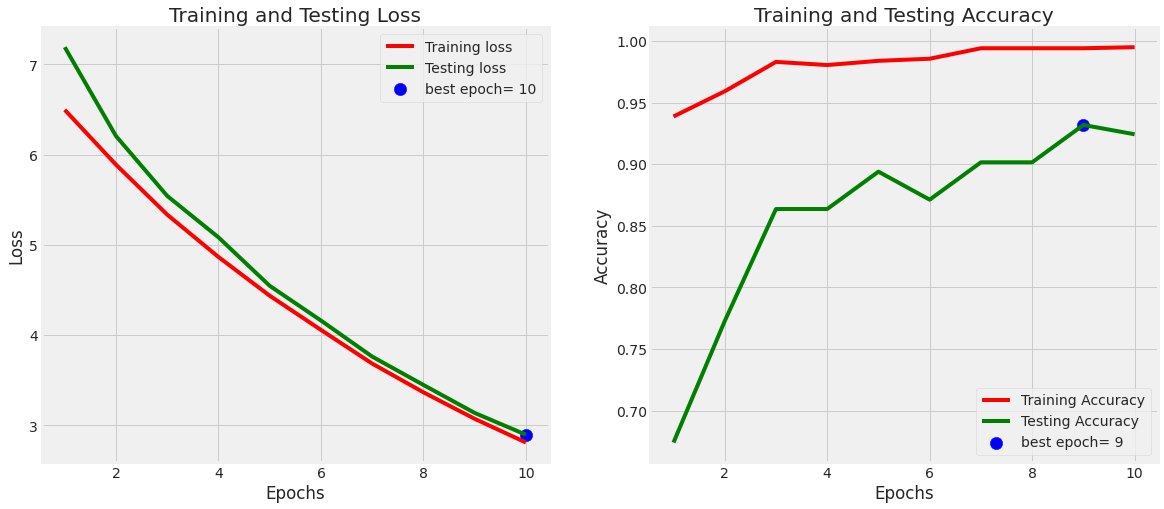

In [14]:
plot_training(history)

In [15]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

149/149 [==============================] - 4s 28ms/step - loss: 2.8968 - accuracy: 0.9242
Train Loss:  2.6711230278015137
Train Accuracy:  1.0
--------------------
Test Loss:  2.8967573642730713
Test Accuracy:  0.9242424368858337


### VGG16

In [16]:
img_size = 224 #in pixels
base_model = tf.keras.applications.vgg16.VGG16(include_top = False,
                       weights = 'imagenet',
                       input_shape = (img_size,img_size,3))

58900480/58889256 [==============================] - 0s 0us/step


In [17]:
for layer in base_model.layers[:-4]: #making unecessary layers untrainable
    layer.trainable = False

In [19]:
model = Sequential()      #creating model architecture
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001), #model compilation
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [21]:
history = model.fit(train_gen,
                        epochs=10,
                        validation_data=test_gen
                        )

Epoch 1/10
30/30 [==============================] - 17s 370ms/step - loss: 1.8254 - accuracy: 0.4037 - val_loss: 1.0079 - val_accuracy: 0.6818
Epoch 2/10
30/30 [==============================] - 8s 251ms/step - loss: 0.8932 - accuracy: 0.6908 - val_loss: 0.5965 - val_accuracy: 0.8106
Epoch 3/10
30/30 [==============================] - 8s 247ms/step - loss: 0.6017 - accuracy: 0.8032 - val_loss: 0.5095 - val_accuracy: 0.8788
Epoch 4/10
30/30 [==============================] - 7s 243ms/step - loss: 0.4276 - accuracy: 0.8560 - val_loss: 0.4048 - val_accuracy: 0.8864
Epoch 5/10
30/30 [==============================] - 7s 240ms/step - loss: 0.2689 - accuracy: 0.9148 - val_loss: 0.4134 - val_accuracy: 0.8864
Epoch 6/10
30/30 [==============================] - 7s 241ms/step - loss: 0.2013 - accuracy: 0.9353 - val_loss: 0.3703 - val_accuracy: 0.8939
Epoch 7/10
30/30 [==============================] - 7s 237ms/step - loss: 0.1475 - accuracy: 0.9497 - val_loss: 0.4053 - val_accuracy: 0.8864
Epoch

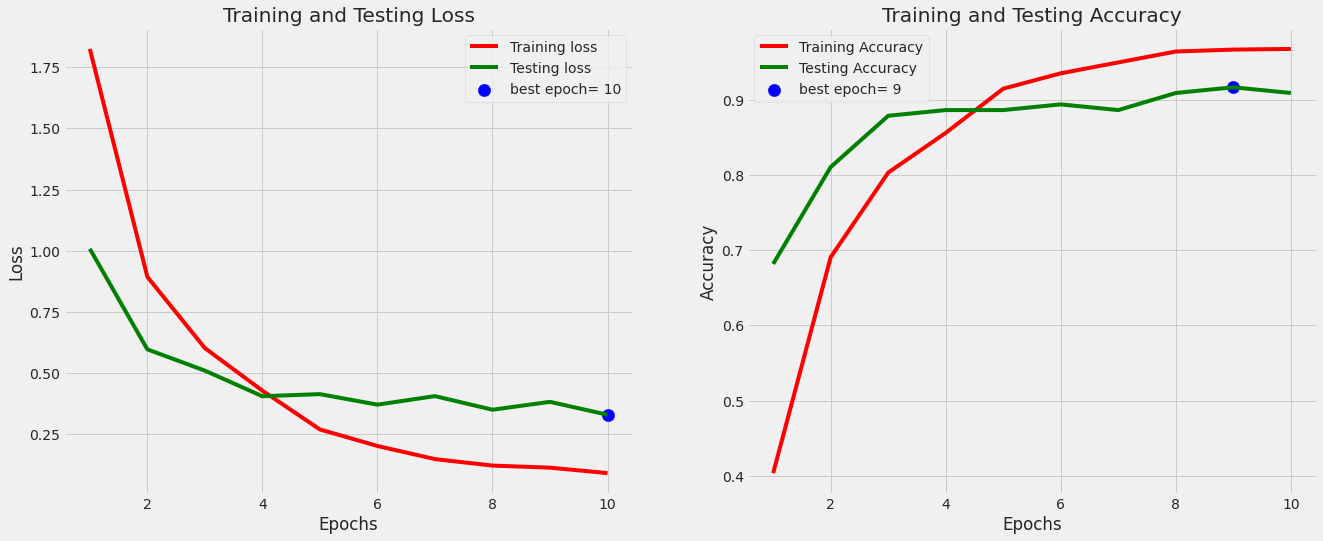

In [22]:
plot_training(history)

### MobileNet

In [27]:
#model compilation
model_mobile =tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet'
)
model_mobile.trainable = False
# adding input and output layers
input_layer = tf.keras.layers.Input(shape=(224,224,3))
x = model_mobile(input_layer,training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(7,activation='softmax')(x)

model_mobile = tf.keras.Model(inputs=[input_layer],outputs=[output])
model_mobile.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              64226304  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 7175      
Total params: 66,491,463
Trainable params: 64,233,479
Non-trainable params: 2,257,984
_______________________________________

In [28]:
earlystop = EarlyStopping(patience=3)
reduce_learning_rate = ReduceLROnPlateau(monitor="val_accuracy",
                                         patience=2, verbose=1,
                                         factor=0.5,  min_lr=0.00001)

callbacks = [earlystop,reduce_learning_rate]
model_mobile.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
history_mobile = model_mobile.fit(train_gen,epochs=15,validation_data=test_gen,callbacks=callbacks)

Epoch 1/15
30/30 [==============================] - 5s 173ms/step - loss: 0.2604 - accuracy: 0.9123 - val_loss: 0.5958 - val_accuracy: 0.7955
Epoch 2/15
30/30 [==============================] - 5s 167ms/step - loss: 0.2332 - accuracy: 0.9233 - val_loss: 0.5484 - val_accuracy: 0.8409
Epoch 3/15
30/30 [==============================] - 6s 204ms/step - loss: 0.2326 - accuracy: 0.9165 - val_loss: 0.6613 - val_accuracy: 0.8106
Epoch 4/15
30/30 [==============================] - 5s 162ms/step - loss: 0.2076 - accuracy: 0.9242 - val_loss: 0.5317 - val_accuracy: 0.8258

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/15
30/30 [==============================] - 6s 188ms/step - loss: 0.1657 - accuracy: 0.9506 - val_loss: 0.5482 - val_accuracy: 0.8409
Epoch 6/15
30/30 [==============================] - 9s 296ms/step - loss: 0.1365 - accuracy: 0.9659 - val_loss: 0.5098 - val_accuracy: 0.8561
Epoch 7/15
30/30 [==============================] - 8s 272ms/step -

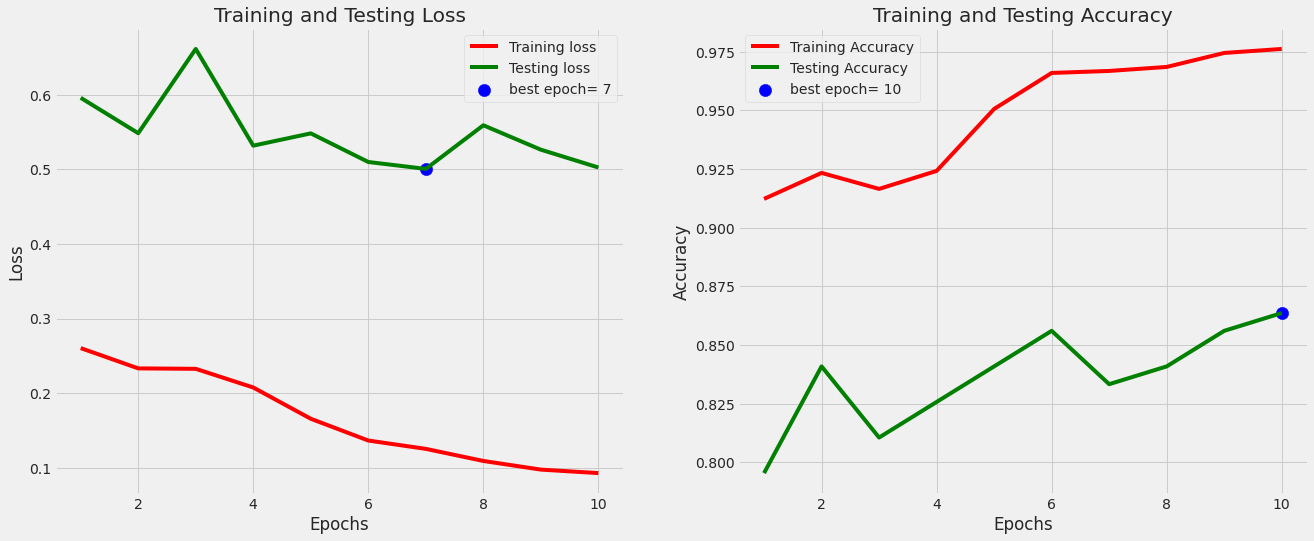

In [39]:
plot_training(history_mobile)

In [32]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

149/149 [==============================] - 1s 8ms/step - loss: 0.3290 - accuracy: 0.9091
Train Loss:  0.020375851541757584
Train Accuracy:  0.9948892593383789
--------------------
Test Loss:  0.3289930820465088
Test Accuracy:  0.9090909361839294


### DenseNet

In [34]:
#model architecture
model_DenseNet =tf.keras.applications.DenseNet201(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet'
)
model_DenseNet.trainable = False
#adding input and output layers
input_layer = tf.keras.layers.Input(shape=(224,224,3))
x = model_DenseNet(input_layer,training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(7,activation='softmax')(x)

model_DenseNet = tf.keras.Model(inputs=[input_layer],outputs=[output])
model_DenseNet.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten_3 (Flatten)          (None, 94080)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              96338944  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 7175      
Total params: 114,668,103
Trainable params: 96,346,119
Non-trainable params: 18,321,984
_____________________________________

In [35]:
model_DenseNet.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model compilation

In [44]:
#model training
history_dense = model_DenseNet.fit(train_gen,epochs=20,validation_data=test_gen)

Epoch 1/20
30/30 [==============================] - 9s 305ms/step - loss: 0.5233 - accuracy: 0.7871 - val_loss: 0.8846 - val_accuracy: 0.7803
Epoch 2/20
30/30 [==============================] - 9s 310ms/step - loss: 0.5164 - accuracy: 0.8083 - val_loss: 0.8569 - val_accuracy: 0.7727
Epoch 3/20
30/30 [==============================] - 9s 317ms/step - loss: 0.5119 - accuracy: 0.7802 - val_loss: 0.7995 - val_accuracy: 0.7576
Epoch 4/20
30/30 [==============================] - 9s 311ms/step - loss: 0.5117 - accuracy: 0.8109 - val_loss: 0.7787 - val_accuracy: 0.7803
Epoch 5/20
30/30 [==============================] - 9s 308ms/step - loss: 0.4953 - accuracy: 0.7990 - val_loss: 0.8088 - val_accuracy: 0.7652
Epoch 6/20
30/30 [==============================] - 9s 305ms/step - loss: 0.4687 - accuracy: 0.8152 - val_loss: 0.7219 - val_accuracy: 0.8030
Epoch 7/20
30/30 [==============================] - 9s 306ms/step - loss: 0.4774 - accuracy: 0.8118 - val_loss: 0.7332 - val_accuracy: 0.8106
Epoch 

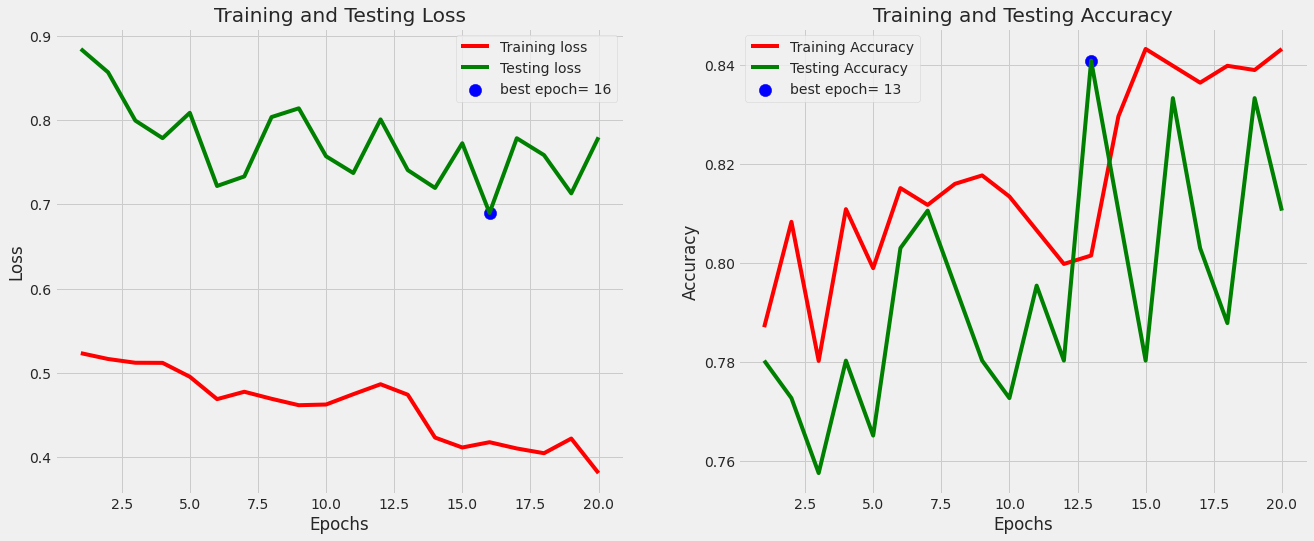

In [45]:
plot_training(history_dense)